<a href="https://colab.research.google.com/github/jainxy/retinanet_task/blob/master/Retinanet_finetune_selfDrivingDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation and Setup environment

In [1]:
# This will automatically help adding GPU to the runtime
!nvidia-smi

Wed Apr 15 07:57:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# Install required packages

## keras-retinanet to use compatible pretrained retinanet backbone
!git clone https://github.com/fizyr/keras-retinanet.git
%cd keras-retinanet/
!pip install .
!python setup.py build_ext --inplace
%cd ../

## to use script for converting Udacity Self-driving dataset annotation into the COCO format.
!git clone https://github.com/jainxy/convert2COCO.git

# keras and tensorflow packages
!pip install --upgrade keras

fatal: destination path 'keras-retinanet' already exists and is not an empty directory.
/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170863 sha256=6a6ca482648775eda66e8b7ba76f5d5765451ba3005cd3eded99a50e44f47718
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1
running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils
/content
fatal: destination path 'convert2COCO' already exists and is not an empty directory.
Requirement already up-to-date: keras in /usr/local/lib/pyth

In [3]:
# Import packages

%tensorflow_version  1.x  # Ensure tensorflow 2.x package is imported 
import tensorflow as tf  # Tensorflow 2.x package.
# import tensorflow_hub as hub  # Tensorflow Hub package to get pretrained models.
from tensorboard import notebook # tensorboard to manage in-notebook Tensorboard instances
print(tf.version)
# %load_ext tensorboard # load the TensorBoard notebook extension

import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

import cv2
import pycocotools
from PIL import Image

import os, time, sys, glob, subprocess, pathlib # !!! clean before submission !!!
import urllib
import csv

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Ensure tensorflow 2.x package is imported`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
<module 'tensorflow._api.v1.version' from '/tensorflow-1.15.2/python3.6/tensorflow_core/_api/v1/version/__init__.py'>


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print("GPUs available - {}".format(tf.test.is_gpu_available()))

GPUs available - True


In [0]:
# defines/functions

def check_create_path(path):
  '''
  Check if path exists else create
  '''
  if not os.path.exists(path):
    os.makedirs(path)
    print("Created Path - ", path)
  else:
    print("Path - ", path, " exists!")

def draw_bbox(img, bbox, color, thickness=20, label = None):
    """ Draws a bounding-box on an image with a given color.
    # Arguments
        img     : The image to draw on.
        bbox       : A list of 4 elements (x1, y1, x2, y2).
        color     : The color of the box.
        thickness : The thickness of the lines to draw a box with.
    """
    bbox = np.array(bbox).astype(int)
    print(bbox)
    cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness, cv2.LINE_AA)
    if label is not None:
        font = cv2.FONT_HERSHEY_PLAIN
        fontColor = (255, 255, 255)
        cv2.putText(img, label.upper(), (bbox[0], bbox[1] - 10), font, 8, fontColor, 15)

def disp_objects_img(img_row):
    img_name = img_row.Frame
    img_path = os.path.join(img_name)
    bbox = [img_row.xmin, img_row.ymin, img_row.xmax, img_row.ymax]
    label = img_row.Label
    img = cv2.imread(img_path)

    img_draw = img.copy()
    img_draw = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

    draw_bbox(img_draw, bbox, color=(255, 255, 0), label=label)

    plt.axis('off')
    plt.imshow(img_draw)
    plt.show()

In [0]:
# global/constants/flags

STORAGE_USE_GDRIVE = False  # Use google-drive for persistent storage and training checkpoints

_URL_IMG = "https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz"
_URL_LABEL = "https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv"

CLASS_NAMES = ["Car", "Truck", "Pedestrian"]
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# Set random-seed for reproducibility
RANDOM_SEED = 101
np.random.seed(RANDOM_SEED)
tf.random.set_random_seed(RANDOM_SEED)

In [7]:
# mount gdrive if flag is True
if STORAGE_USE_GDRIVE:
  from google.colab import drive
  drive.mount('/content/gdrive')
  drive_path = "/content/gdrive/My Drive/"  
else:  # Use Colab VM storage
  drive_path = "/content/"
data_path = os.path.join(drive_path, 'dataset/')
check_create_path(data_path)

Created Path -  /content/dataset/


# Data
## Download -- Clean -- Prepare

In [8]:
# Download and extract the dataset

img_tar_path = os.path.join(data_path, "object-detection-crowdai.tar.gz")
img_dir_path = os.path.join(data_path, "object-detection-crowdai/")
ann_csv_path = os.path.join(data_path, "labels_crowdai.csv")

# check and download the Image-datset tar file
if not os.path.exists(img_tar_path):
  print("Downloading tar file of image dataset ...")
  !wget -c -P "{data_path}" {_URL_IMG}
else:
  print("Tar file of image dataset exists at ", img_tar_path)
# extract tar-file
if not os.path.exists(img_dir_path):
  print("Extracting tar file of image dataset ...")
  !tar -xvf "{img_tar_path}" -C "{data_path}"
else:
  print("Extracted image dataset exists at ", img_dir_path)
img_dir_path = pathlib.Path(img_dir_path)

# check and download the Annotation CSV file
if not os.path.exists(ann_csv_path):
  print("Downloading Annotation CSV file ...")
  !wget -c -P "{data_path}" {_URL_LABEL}
else:
  print("Annotation CSV file exists at ", ann_csv_path)
!ls -l

Streaming output truncated to the last 5000 lines.
object-detection-crowdai/1479500479108118032.jpg
object-detection-crowdai/1479505896977290269.jpg
object-detection-crowdai/1479502732262685732.jpg
object-detection-crowdai/1479504529380876184.jpg
object-detection-crowdai/1479498523474278730.jpg
object-detection-crowdai/1479504079850872865.jpg
object-detection-crowdai/1479504508380432615.jpg
object-detection-crowdai/1479499621549613570.jpg
object-detection-crowdai/1479499032008420832.jpg
object-detection-crowdai/1479500827631366146.jpg
object-detection-crowdai/1479500867636693489.jpg
object-detection-crowdai/1479500252592366246.jpg
object-detection-crowdai/1479503310799120636.jpg
object-detection-crowdai/1479502111718917209.jpg
object-detection-crowdai/1479504179357736789.jpg
object-detection-crowdai/1479505516947324445.jpg
object-detection-crowdai/1479502084716200872.jpg
object-detection-crowdai/1479502846768058414.jpg
object-detection-crowdai/1479505432442701004.jpg
object-detection-c

In [9]:
img_l = img_dir_path.glob('*.jpg')
nImg = len(list(img_l))
print("Number of images - %d" % nImg)

Number of images - 9420


In [10]:
# Prepare dataset for training
%cd {data_path}
!ls
IMG_DIR = "object-detection-crowdai"
anno_coco_file = "labels_crowdai_coco.json"
# Read existing csv as dataframe
df_anno = pd.read_csv("labels_crowdai.csv")
# Filter dataset for incorrect labelling
df_anno = df_anno[(df_anno['xmax']>df_anno['xmin']) & (df_anno['ymax']>df_anno['ymin'])]
print(df_anno.shape)
# transform data as per the requiremnts of training script
col_names = ['Frame', 'xmin', 'ymin', 'xmax', 'ymax', 'Label']
df_anno = df_anno.reindex(columns=col_names)
df_anno['Frame'] = df_anno['Frame'].apply(lambda x: os.path.join(IMG_DIR, x))

df_anno.head()

/content/dataset
labels_crowdai.csv  object-detection-crowdai  object-detection-crowdai.tar.gz
(72060, 7)


,Frame,xmin,ymin,xmax,ymax,Label
0,object-detection-crowdai/1479498371963069978.jpg,785,533,905,644,Car
1,object-detection-crowdai/1479498371963069978.jpg,89,551,291,680,Car
2,object-detection-crowdai/1479498371963069978.jpg,268,546,383,650,Car
3,object-detection-crowdai/1479498371963069978.jpg,455,522,548,615,Truck
4,object-detection-crowdai/1479498371963069978.jpg,548,522,625,605,Truck


In [0]:
# Split dataset into training-testing folds
train_df, test_df = train_test_split(
  df_anno, 
  test_size=0.2, 
  random_state=RANDOM_SEED
)

[  0 544 299 789]


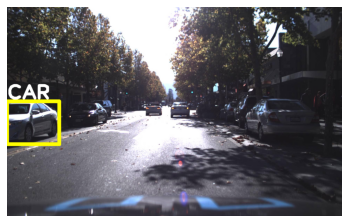

[893 533 923 563]


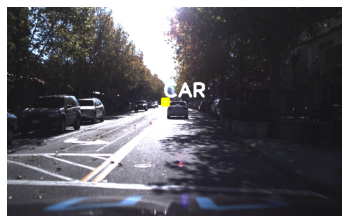

In [12]:
# Display some samples
disp_objects_img(test_df.iloc[31])
disp_objects_img(train_df.iloc[18])

In [13]:
# save annotations as csv files for the training script
ANNOTATIONS_TRAIN_FILE = 'annotations_train.csv'
ANNOTATIONS_TEST_FILE = 'annotations_test.csv'
CLASSES_FILE = 'classes.csv'
train_df.to_csv(ANNOTATIONS_TRAIN_FILE, index=False, header=None)
test_df.to_csv(ANNOTATIONS_TEST_FILE, index=False, header=None)

classes = sorted(df_anno.Label.unique())
with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(sorted(classes)):
    f.write('{},{}\n'.format(line,i))

ANNOTATIONS_TRAIN_FILEPATH = os.path.join(os.getcwd(), ANNOTATIONS_TRAIN_FILE)
ANNOTATIONS_TEST_FILEPATH = os.path.join(os.getcwd(), ANNOTATIONS_TEST_FILE)
CLASSES_FILEPATH = os.path.join(os.getcwd(), CLASSES_FILE)

## List files and head-content of the csv files
!ls
%cd /content/
!head "{ANNOTATIONS_TRAIN_FILEPATH}" -n 3
!head "{ANNOTATIONS_TEST_FILEPATH}" -n 3
!head "{CLASSES_FILEPATH}"

annotations_test.csv   classes.csv	   object-detection-crowdai
annotations_train.csv  labels_crowdai.csv  object-detection-crowdai.tar.gz
/content
object-detection-crowdai/1479503944322290167.jpg,650,568,695,607,Car
object-detection-crowdai/1479504559883215179.jpg,605,564,681,630,Car
object-detection-crowdai/1479502077716170613.jpg,508,580,610,652,Car
object-detection-crowdai/1479505939475902144.jpg,328,590,364,626,Car
object-detection-crowdai/1479498377463264578.jpg,1560,593,1637,653,Car
object-detection-crowdai/1479504698892976645.jpg,361,290,1238,1049,Car
Car,0
Pedestrian,1
Truck,2


# Training

In [14]:
# Download pretrained retinanet backbone
snapshot_path = os.path.join(drive_path, 'models/')
os.makedirs(snapshot_path, exist_ok=True)
PRETRAINED_MODEL = os.path.join(snapshot_path, 'pretrained_model.h5')

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
if not os.path.exists(PRETRAINED_MODEL):
  urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)
  print('Downloaded pretrained model to ' + PRETRAINED_MODEL)
else:
  print('Pretrained model present at ' + PRETRAINED_MODEL)

# Tensorboard logs directory
tblogs_path = os.path.join(drive_path, 'tblogs/')
os.makedirs(tblogs_path, exist_ok=True)

Downloaded pretrained model to /content/models/pretrained_model.h5


In [0]:
%cd keras-retinanet/

!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights "{PRETRAINED_MODEL}" \
--batch-size 8 --steps 1000 --epochs 10 --snapshot-path "{snapshot_path}" --compute-val-loss --weighted-average \
--tensorboard-dir "{tblogs_path}" csv "{ANNOTATIONS_TRAIN_FILEPATH}" "{CLASSES_FILEPATH}" \
--val-annotations "{ANNOTATIONS_TEST_FILEPATH}"

/content/keras-retinanet
mkdir: cannot create directory ‘./tblogs/’: File exists
Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 27) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1319: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((27,) vs (720,)).
  weight_values[i].shape))
2020-04-15 08:00:14.531379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-15 08:00:14.535019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one

In [0]:
# Command bin/dump
'''
notebook.list()
notebook.display(port=6006, height=1000)
# path_to_tar = tf.keras.utils.get_file(os.path.join(data_path, 'object-detection-crowdai'), origin=_URL_IMG, extract=True)
image_count = len(list(data_dir.glob('*/*.jpg')))
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))



'''

In [0]:
glob.glob(os.path.join("/content/gdrive/My Drive/", "*.jpg"))

[]

In [0]:
for filepath in glob.glob(os.path.join("/content/gdrive/My Drive/", "*.jpg")):
  os.remove(filepath)
  # !rm -f "{filepath}"

In [0]:
# !for file in `ls -a "/content/gdrive/My Drive/"`; do rm -f "/content/gdrive/My Drive/"$file; done